In [64]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
df_VWCE=pd.read_csv('Datasets/vwce.csv')
df_SP500=pd.read_csv('Datasets/sp500.csv')
df_APPLE=pd.read_csv('Datasets/apple.csv')
df_MSCI=pd.read_csv('Datasets/msci.csv')
df_NAS=pd.read_csv('Datasets/nasdaq.csv')
df_EIMI=pd.read_csv("Datasets/eimi.csv")
sns.set(style="darkgrid")

Data Loading and Cleaning section. Merging to all-in-one dataframe.

In [65]:
# Date conversion for every dataframe 
dfs = [df_SP500, df_MSCI, df_EIMI,df_APPLE, df_NAS]
ordered_dfs = []

for df in dfs:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    ordered_dfs.append(df.sort_values(by='Date', ascending=True).copy())

df_SP500_ordered, df_MSCI_ordered, df_EIMI_ordered, df_APPLE_ordered, df_NAS_ordered = ordered_dfs

#VWCE separated as it has a different date format
df_VWCE_ordered = df_VWCE.copy() 
df_VWCE_ordered['Date'] = pd.to_datetime(df_VWCE_ordered['Date'])
df_VWCE_ordered = df_VWCE_ordered.sort_values(by='Date', ascending=True).copy()

In [66]:
dfs = [df_VWCE_ordered, df_SP500_ordered, df_MSCI_ordered, df_EIMI_ordered, df_APPLE_ordered, df_NAS_ordered]

# Setting date as index
for df in dfs:
    df.set_index('Date', inplace=True)

    # Removing % symbol and convert to float
for df in dfs:
    df['Change %'] = df['Change %'].replace('%', '', regex=True)  # Rimuove '%'
    df['Change %'] = df['Change %'].astype(float)  # Converte in float

In [67]:
# The Sp500 CSV uses ',' as separator, i need to replace it as i want a float value
columns_to_edit = ['Price', 'Open', 'High', 'Low']
for col in columns_to_edit:
    df_SP500_ordered[col] = df_SP500_ordered[col].str.replace(',', '').astype(float)

columns_to_edit = ['Price', 'Open', 'High', 'Low']
for col in columns_to_edit:
    df_NAS_ordered[col] = df_NAS_ordered[col].str.replace(',', '').astype(float)

In [68]:
scaler=MinMaxScaler()
dfs2 = [df_SP500_ordered, df_NAS_ordered, df_EIMI_ordered, df_APPLE_ordered, df_MSCI_ordered]
columns = ['Price', 'Price', 'Price', 'Price', 'Price']  # Colonna 'Price' per tutti tranne MSCI

for i, df in enumerate(dfs2):
    # Normalize prices
    df['Normalized Price'] = scaler.fit_transform(df[[columns[i]]])

In [69]:
df_merged = df_SP500_ordered[['Normalized Price']].merge(
    df_NAS_ordered[['Normalized Price']], 
    left_index=True, 
    right_index=True, 
    suffixes=('_SP500', '_NAS')
)

df_merged = df_merged.merge(
    df_EIMI_ordered[['Normalized Price']], 
    left_index=True, 
    right_index=True,
    suffixes=('', '_EIMI')
)

df_merged = df_merged.merge(
    df_APPLE_ordered[['Normalized Price']], 
    left_index=True, 
    right_index=True, 
    suffixes=('', '_APPLE')
)

df_merged = df_merged.merge(
    df_MSCI_ordered[['Normalized Price']], 
    left_index=True, 
    right_index=True, 
    suffixes=('', '_MSCI')
)

df_merged = df_merged.rename(columns={'Normalized Price': 'Normalized Price_EIMI'})

In [70]:
df_merged2 = df_SP500_ordered[['Price']].merge(
    df_NAS_ordered[['Price']], 
    left_index=True, 
    right_index=True, 
    suffixes=('_SP500', '_NAS')
)

df_merged2 = df_merged2.merge(
    df_EIMI_ordered[['Price']], 
    left_index=True, 
    right_index=True,
    suffixes=('', '_EIMI')
)

df_merged2 = df_merged2.merge(
    df_APPLE_ordered[['Price']], 
    left_index=True, 
    right_index=True, 
    suffixes=('', '_APPLE')
)

df_merged2 = df_merged2.merge(
    df_MSCI_ordered[['Price']], 
    left_index=True, 
    right_index=True, 
    suffixes=('', '_MSCI')
)

df_merged2 = df_merged2.rename(columns={'Price': 'Price_EIMI'})

Exploratory Data Analysis

In [71]:
#Check correlation between VWCE and Sp500
df_VWCE_ordered['Price'].corr(df_SP500_ordered['Price'])

#As we could expect, almost perfect correlation

np.float64(0.9816484890527348)

Text(0, 0.5, 'Price SP500')

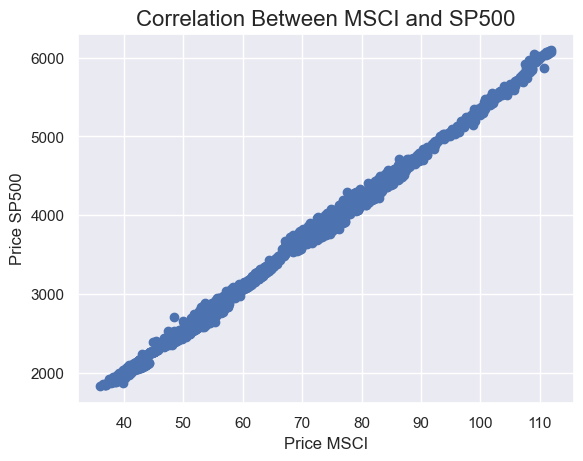

In [72]:
#As the result of the concentration of US stocks in FTSE-All World, we can see a nearly perfect positive correlation

plt.scatter(df_merged2['Price_MSCI'], df_merged2['Price_SP500'])
plt.title("Correlation Between MSCI and SP500", fontsize=16)
plt.xlabel("Price MSCI", fontsize=12)
plt.ylabel("Price SP500", fontsize=12)

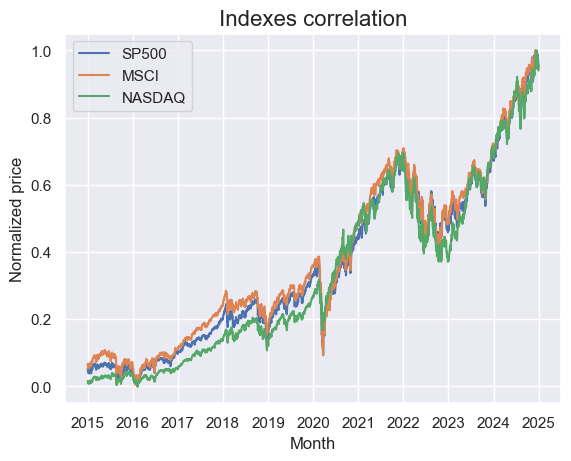

In [73]:
#Normalizing prices we can clearly see a strong correlation between MSCI World, SP500 and Nasdaq100. 
#Nasdaq and Sp500 have better performance but higher volatility.

plt.plot(df_SP500_ordered.index, df_SP500_ordered['Normalized Price'], label="SP500")
plt.plot(df_MSCI_ordered.index, df_MSCI_ordered['Normalized Price'], label="MSCI")
plt.plot(df_NAS_ordered.index, df_NAS_ordered['Normalized Price'], label="NASDAQ")
plt.title("Indexes correlation", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Normalized price", fontsize=12)
plt.legend()
plt.show()

<Axes: >

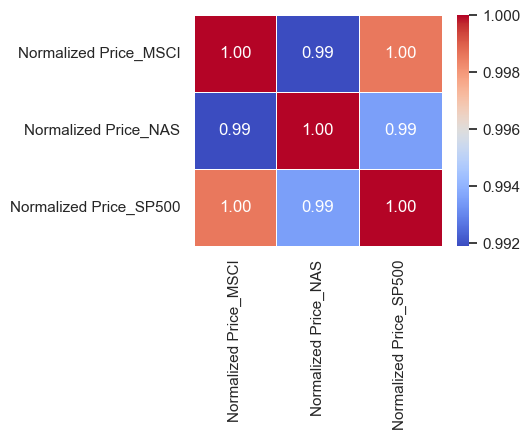

In [74]:
#Heat map confirms the correlation between indexes

corr_matrix = df_merged[['Normalized Price_MSCI', 'Normalized Price_NAS', 'Normalized Price_SP500']].corr()
plt.figure(figsize=(4, 3)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

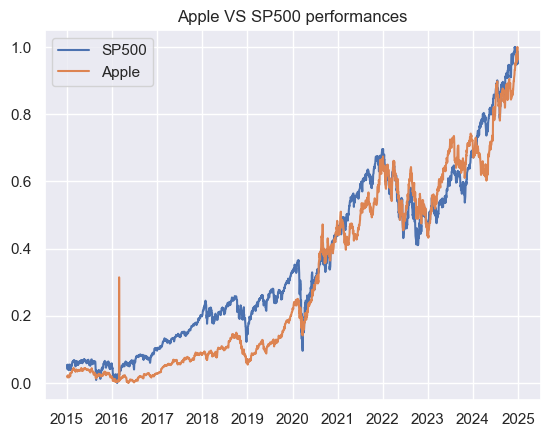

In [75]:
plt.plot(df_SP500_ordered.index, df_SP500_ordered['Normalized Price'], label="SP500")
plt.plot(df_APPLE_ordered.index, df_APPLE_ordered['Normalized Price'], label="Apple")
plt.title("Apple VS SP500 performances")
plt.legend()
plt.show()

#The graphic shows Apple matches the index most of the time, with obviously highter volatily.

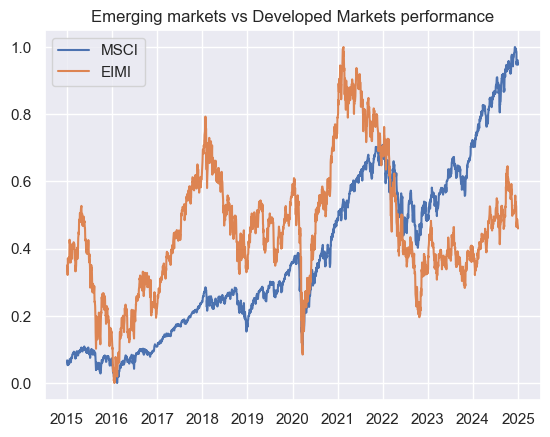

In [76]:
#Looking at emerging markets and developed markets correlation: they are very correlated but EIMI has higher volatility.
#Are we really diversifing? The rule is to invest in different countries, but the last years they move the same.

plt.plot(df_MSCI_ordered.index, df_MSCI_ordered['Normalized Price'], label="MSCI")
plt.plot(df_EIMI_ordered.index, df_EIMI_ordered['Normalized Price'], label="EIMI")
plt.title("Emerging markets vs Developed Markets performance")
plt.legend()
plt.show()

Prediction Systems with deeplearning: MLP and LSTM 

In [77]:
# Some deep learning: MLP
X = df_merged2[['Price_NAS', 'Price_SP500']].values  # Input
y = df_merged2['Price_APPLE'].values  # Target

# Convert to tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Target deve essere una colonna

# Divisione in set di addestramento e validazione (80% training, 20% validazione)
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Definire il modello
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(2, 64)  #input
        self.fc2 = nn.Linear(64, 32)  #hidden layer
        self.fc3 = nn.Linear(32, 1)   # Un output
        self.dropout = nn.Dropout(0.3)  # 30% dei neuroni disattivati

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleModel()

# Loss and optimization function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 70
for epoch in range(epochs):
    model.train()  # Impostiamo il modello in modalità addestramento

    # Addestramento sui dati di training
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Fase di validazione
    model.eval()  # Impostiamo il modello in modalità di valutazione
    with torch.no_grad():  # Disabilita il calcolo dei gradienti durante la validazione
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    # Stampare i risultati ogni 10 epoche
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# Predizione finale
prezzo1_input = 21150
prezzo2_input = 6050

input_data = torch.tensor([[prezzo1_input, prezzo2_input]], dtype=torch.float32)

# Predizione
model.eval()
predizione = model(input_data)

print(f"Prediction: {predizione.item():.2f}")


Epoch [10/70], Training Loss: 3806.0906, Validation Loss: 12604.6279
Epoch [20/70], Training Loss: 11056.9258, Validation Loss: 12094.7559
Epoch [30/70], Training Loss: 6568.2017, Validation Loss: 5036.3848
Epoch [40/70], Training Loss: 2341.6919, Validation Loss: 2163.6226
Epoch [50/70], Training Loss: 2285.1887, Validation Loss: 2223.0703
Epoch [60/70], Training Loss: 1704.0095, Validation Loss: 1572.0961
Epoch [70/70], Training Loss: 1377.3069, Validation Loss: 1374.2235
Prediction: 212.78


Epoch 10/100, Train Loss: 0.0303, Val Loss: 0.0410
Epoch 20/100, Train Loss: 0.0264, Val Loss: 0.0473
Epoch 30/100, Train Loss: 0.0245, Val Loss: 0.0436
Epoch 40/100, Train Loss: 0.0174, Val Loss: 0.0111
Epoch 50/100, Train Loss: 0.0054, Val Loss: 0.0030
Epoch 60/100, Train Loss: 0.0025, Val Loss: 0.0054
Epoch 70/100, Train Loss: 0.0015, Val Loss: 0.0028
Epoch 80/100, Train Loss: 0.0010, Val Loss: 0.0016
Epoch 90/100, Train Loss: 0.0008, Val Loss: 0.0013
Epoch 100/100, Train Loss: 0.0007, Val Loss: 0.0011


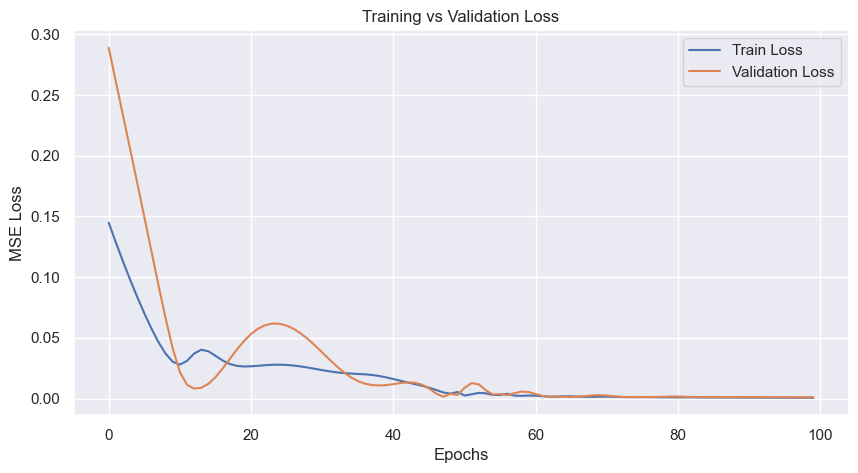

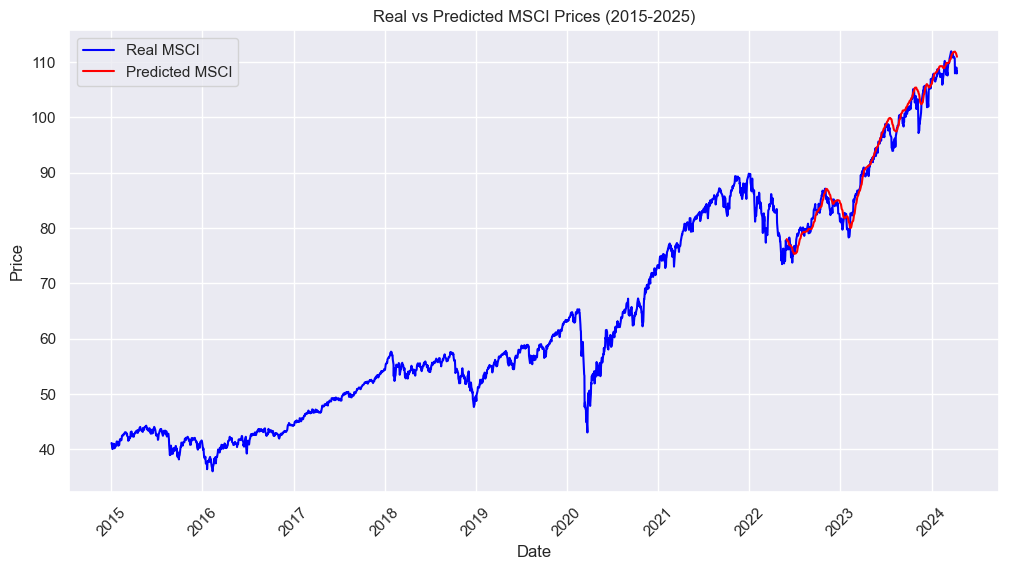


Next MSCI prediction (April 2025):
MSCI=110.82


In [78]:
#LSTM: time series prediction of MSCI world 

def create_sequence(df, window_size):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df[i-window_size:i, :]) 
        y.append(df[i, :])
    return np.array(X), np.array(y)

data = df_merged2[['Price_MSCI']].values
dates = df_merged2.index  

# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

window_size = 180
X, y = create_sequence(data_scaled, window_size)

# Split: 70% train, 10% val, 20% test
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

# Conversion to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) 
        return out

# Model parameters
input_size = 1
hidden_layer_size = 64
output_size = 1
model = LSTMModel(input_size, hidden_layer_size, output_size)

# Funzione di perdita e ottimizzatore
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training with validation
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Plot loss curve
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# Predictions on the test set
model.eval()
with torch.no_grad():
    predictions = model(X_test)

# Back to real data
predictions = scaler.inverse_transform(predictions.numpy().reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

test_dates = dates[train_size+val_size:train_size+val_size+len(y_test)]
predicted_df = pd.DataFrame(predictions, index=test_dates, columns=['Predicted_MSCI'])

real_data = np.concatenate((data[:train_size+val_size], y_test_inv), axis=0)
real_dates = np.concatenate((dates[:train_size+val_size], test_dates), axis=0)
predicted_data = np.concatenate((real_data, predictions), axis=0)

# Plot 
plt.figure(figsize=(12, 6))
plt.plot(real_dates, real_data[:, 0], label='Real MSCI', color='blue')  
plt.plot(predicted_df.index, predicted_df['Predicted_MSCI'], label='Predicted MSCI', color='red') 
plt.title('Real vs Predicted MSCI Prices (2015-2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Prediction
last_window = data_scaled[-window_size:]  
last_window = torch.tensor(last_window, dtype=torch.float32).unsqueeze(0)

model.eval()
with torch.no_grad():
    future_prediction = model(last_window)

future_prediction = scaler.inverse_transform(future_prediction.numpy())

print("\nNext MSCI prediction (April 2025):")
print(f"MSCI={future_prediction[0][0]:.2f}")






Now let's do something different! Hypotize an investment portfolio in VWCE and find:

    - The return of the investment
    - The compound annual growth ratio
    - Sharpe ratio

In [79]:
initial_investment=10000
n_shares=initial_investment/df_VWCE_ordered['Price'].iloc[0]
total=n_shares*df_VWCE_ordered['Price'].iloc[-1]

print("Total amount of the investing portfolio after 5 years:", total)

Total amount of the investing portfolio after 5 years: 16798.4496124031


In [80]:
monthly_investment = 100 
initial_investment = 10000
investment_values = []
n_shares = initial_investment / df_VWCE_ordered['Price'].iloc[0]

# Add to portfolio
investment_values.append(n_shares * df_VWCE_ordered['Price'].iloc[0])

# Buy shares every 30 days
purchase_interval = 30
current_day = df_VWCE_ordered.index[0]  


for i in range(1, len(df_VWCE_ordered)):
    if (df_VWCE_ordered.index[i] - current_day).days >= purchase_interval:
        price = df_VWCE_ordered['Price'].iloc[i]
        month_shares = monthly_investment / price  # Number of shares you buy this month
        n_shares += month_shares 
        investment_values.append(n_shares * price)  
        current_day = df_VWCE_ordered.index[i]  

    else:
        investment_values.append(n_shares * df_VWCE_ordered['Price'].iloc[i])

df_VWCE_ordered['Investment Value'] = investment_values
print(df_VWCE_ordered[['Price', 'Investment Value']])

             Price  Investment Value
Date                                
2020-01-02   77.40      10000.000000
2020-01-03   77.35       9993.540052
2020-01-06   77.10       9961.240310
2020-01-07   77.59      10024.547804
2020-01-08   77.80      10051.679587
...            ...               ...
2025-03-20  128.74      25001.030687
2025-03-21  128.38      24931.119462
2025-03-24  130.46      25335.050982
2025-03-25  130.60      25362.238680
2025-03-26  130.02      25249.603930

[1335 rows x 2 columns]


Text(0, 0.5, 'Value')

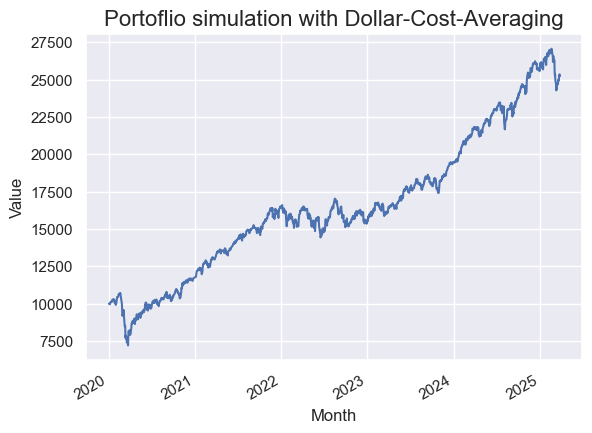

In [81]:
df_VWCE_ordered['Investment Value'].plot(kind='line')
plt.title("Portoflio simulation with Dollar-Cost-Averaging", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Value", fontsize=12)

#The chart suggests that dollar-cost averaging makes the portfolio growth more stable. Good for risk-aver people

In [82]:
#Now some statistics! Sharpe ratio, ROI and CAGR

#CAGR
num_rows = len(df_VWCE_ordered)
CAGR=((df_VWCE_ordered['Investment Value'].iloc[-1]/initial_investment)**0.2)-1
print(CAGR)

0.2035133554225783


In [83]:
#Return on investment
total_investment=initial_investment+monthly_investment*(len(df_VWCE_ordered)/30)
ROI=(df_VWCE_ordered['Investment Value'].iloc[-1]-total_investment)/total_investment*100
print(ROI) 

#Almost 75% of ROI, good one

74.73774345915703


In [84]:
#Monthly sharpe ratio

mean_return = df_VWCE_ordered['Change %'].mean()
std_deviation = df_VWCE_ordered['Change %'].std()
risk_free_rate = 0.00001 #As hypotesis i use German Bund: 2.5%-year
sharpe_ratio_giornaliero = (mean_return - risk_free_rate) / std_deviation
sharpe_ratio_annualized = sharpe_ratio_giornaliero * np.sqrt(252*5)
print(sharpe_ratio_annualized)

#This sharpe ratio suggests we are in a bull market, the stock market performs well even though Bonds have been high cause of BCE and FED interest rate to fight inflation

1.5121854194844953
